<center> 
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5c/Logo_Mondragon_Unibertsitatea.png" width="150" height="100" float ="left">
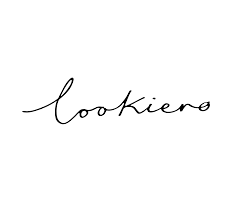    


---
<h3>Beñat Basabe, Jon Jarrín, June Pagaldai, Daniel Puente, Eneko Rentería | <font color='red'> Equipo Rojo<h3>

## Generación de grafos
Se genera el grafo que posteriormente se empleará para entrenar el modelo.

### Carga de librerias 
---

- **General**

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import pickle

def guardar_pikle(df, name):
    with open(dir_out + str(name) + '.pkl', 'wb') as fp: pickle.dump(df, fp)

def abrir_pikle(name):
    with open(dir_out + str(name) + '.pkl', 'rb') as fp: df = pickle.load(fp)
    return df

In [2]:
import warnings
warnings.filterwarnings('ignore')

- **Pyspark**

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.functions import col

- **Strings**

In [4]:
from collections import Counter
import re

- **Visualización**

In [5]:
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

* **Grafos**

In [6]:
import networkx as nx

- **Otros**

In [7]:
import itertools

## Funciones a utilizar
---

In [8]:
dir_in, dir_out = "../../datos/datos_originales/", "../../datos/datos_desarrollo/"

spark = SparkSession \
    .builder \
    .appName("how to read csv file") \
    .getOrCreate()

- Función para **dar nombre** a la variable **family_id** mediante la variable title

In [9]:
def get_family_name(id_):
    
    filtered = product.filter(product.family_id == id_)
    string = ' '.join([x['title'] for x in filtered.select('title').collect()]).lower()
    
    return id_, Counter(string.split()).most_common(1)[0][0]

- Función para crear los **sufijos** y facilitar el *join*

In [10]:
def rename_columns(df, suffix):
    ''' Renombra las columnas de un dataframe.'''
    for names in df.schema.names: df = df.withColumnRenamed(names,names + suffix)
    return df

* Función para conseguir valores únicos de una variable en *pyspark*

In [11]:
def get_value(dffs, variable):
    return list(dffs.select(dffs[variable]).distinct().toPandas()[variable])

* Función que crea el grafo filtrando por temporada

In [12]:
def sacar_productos(e, variable, tallas = False):
    if tallas:
        list_1 = df_para_filtrar[(df_para_filtrar[variable] == e[0]) | (df_para_filtrar[variable] == 'UNQ')].index.to_list()
        list_2 = df_para_filtrar[(df_para_filtrar[variable] == e[1]) | (df_para_filtrar[variable] == 'UNQ')].index.to_list()
    else:
        list_1 = df_para_filtrar[df_para_filtrar[variable] == e[0]].index.to_list()
        list_2 = df_para_filtrar[df_para_filtrar[variable] == e[1]].index.to_list()

    return list(itertools.product(list_1, list_2))

def create_graph(o):
    
    ##############
    ##### DF #####  
    ##############

    ### Filtrar por temporada ###
    df2 = df.filter(df.season == o)
    
    ### Conseguir variantes de productos únicos#####
    vu_id_product = get_value(df2, 'id_product')
    
    ### Crear df para filtrar ###
    df_para_filtrar = pd.DataFrame(vu_id_product).reset_index()
    df_para_filtrar['family_product'] = pd.Series([e[0] for e in df_para_filtrar[0].str.split('_')])
    df_para_filtrar['level'] = df_para_filtrar.family_product.map(niveles)
    df_para_filtrar.columns = ['index', 'id_product', 'family_product', 'level']
    
    def sacar_productos(e, variable, tallas = False):
        if tallas:
            list_1 = df_para_filtrar[(df_para_filtrar[variable] == e[0]) | (df_para_filtrar[variable] == 'UNQ')].index.to_list()
            list_2 = df_para_filtrar[(df_para_filtrar[variable] == e[1]) | (df_para_filtrar[variable] == 'UNQ')].index.to_list()
        else:
            list_1 = df_para_filtrar[df_para_filtrar[variable] == e[0]].index.to_list()
            list_2 = df_para_filtrar[df_para_filtrar[variable] == e[1]].index.to_list()

        return list(itertools.product(list_1, list_2))

    #############
    ### NODOS ###
    #############

    G = nx.Graph()
    
    for i in range(len(vu_id_product)):
            G.add_node(i,
                      color = vu_id_product[i].split('_')[1],
                      size  = vu_id_product[i].split('_')[2],
                      level = df_para_filtrar['level'][i])
            
    ###############        
    ### ARISTAS ###
    ###############

    ### Aristas - Tallas ###
    df_para_filtrar['talla'] = df_para_filtrar['id_product'].apply(lambda x:x.split('_')[-1])
    orden_tallas = ['XXS', 'XS', 'S', 'M', 'L', 'XL', 'XXL', 'XXXL','X4XL']
                
    combinaciones_tallas_letra = []
    for i in range(1, len(orden_tallas)): combinaciones_tallas_letra += [(orden_tallas[i - 1], orden_tallas[i])]
    combinaciones_talla = list(map(sacar_productos, combinaciones_tallas_letra, ['talla'], [True]))[0]
    
    ### Aristas - Level ###
    levels = get_value(df2.filter(df2.id_product.isin(vu_id_product)), 'level')
    levels.sort()
    tods = list(itertools.combinations(levels, 2))
    tods.sort()
    tods += [('3.2', '3.2')]
    tods.remove(('1.1', '1.2'))

    combinaciones_level = list(map(sacar_productos, tods, ['level']))[0]
    
    ### Se añaden todas las aristas ###
    G.add_edges_from(list(set(combinaciones_level + combinaciones_talla)))

    ### Se empieza poniendo un peso de 0 a todas las aristas ###
    for x in G.edges(): G[x[0]][x[1]]['weight'] = 1
    return G



### Cargar datos
---

In [13]:
df = spark.read.csv(dir_out + 'lookiero_*.csv', header=True, inferSchema=True)
df_total = spark.read.csv(dir_out + 'df_total.csv', header=True, inferSchema=True)

In [14]:
df = df.withColumn("level",col("level").cast(StringType()))

In [14]:
df.show()

+--------------------+------+-----+-----------+-------------+---------+--------------------+--------------+----------+-------------+-----+------------+---------------+--------------------+------------------+-----+
|                  id|season|stock|publishable|size_lookiero|    color|          id_product|family_product|name_brand| origin_brand|value|name_feature|multiple_values|      feature_family|id_product_feature|level|
+--------------------+------+-----+-----------+-------------+---------+--------------------+--------------+----------+-------------+-----+------------+---------------+--------------------+------------------+-----+
|498662e5-11e8-483...|     8|    0|       true|            M|     ecru|   cardigan_ecru_M_8|      cardigan|  BRAND112|NO_MAINSTREAM|   55| hip_contour|          false|c6b81db8-29ed-43d...|    hip_contour_55|  2.2|
|dcda2fe4-58e3-4b2...|     8|    0|       true|            S|     ecru|   cardigan_ecru_S_8|      cardigan|  BRAND112|NO_MAINSTREAM|   55| hip_c

### Grafo
---

* Reglas de unión grafos

In [13]:
niveles = {'jumpsuit': '1.1', 
           'dress': '1.1',
           
           'jeans': '1.2',
           'skirt': '1.2',
           'short': '1.2',
           'pant': '1.2',
          
           'shirt': '2.1',
           'top': '2.1',
           'tshirt': '2.1',
          
           'sweater': '2.2',
           'sweatshirt': '2.2',
           'cardigan': '2.2',
          
           'trench': '3.1',
           'coat': '3.1',
           'parka': '3.1',
           'jacket': '3.1',
          
           'bag': '3.2',
           'scarf': '3.2'}

* Ponderaciones de relaciones

In [ ]:
G7, G8, G9 = map(create_graph, [7, 8, 9])
G7.name, G8.name, G9.name = 'G7', 'G8', 'G9'

In [14]:
G7, G8, G9 = abrir_pikle('G7'), abrir_pikle('G8'), abrir_pikle('G9')

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score

In [16]:
from node2vec import Node2Vec
import gensim
gensim.__version__

'4.1.2'

In [17]:
import torch
import torch.nn.functional as F

In [18]:
from torch_geometric.utils import negative_sampling
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges

* Se genera el modelo para hacer el embedding

In [16]:
node2vec = Node2Vec(G7, dimensions=64, walk_length=10, num_walks=10, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)
t10cu_emb = { n: list(map(float,model.wv.get_vector(n))) for n in G7.nodes()}

Computing transition probabilities: 100%|██████████| 2079/2079 [04:03<00:00,  8.52it/s]


* Se incluye el embedding en el nodo

In [18]:
for x, v  in t10cu_emb.items(): G7.nodes[x]['x'] = v

* Embedding manual, es simplemente un one hot enocodding

In [19]:
for v in ['color','size','level']:
    attr = [G7.nodes[x][v] for x in G7.nodes()]

    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(attr)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    guardar_pikle(onehot_encoded, 'onehot_encoded_' + v)

In [20]:
color, size, level = abrir_pikle('onehot_encoded_color'), abrir_pikle('onehot_encoded_size'), abrir_pikle('onehot_encoded_level')
encoding = np.concatenate((color, size, level), axis=1)

for k, v in enumerate(encoding.tolist()): G7.nodes[k]['x_encoded'] = v

* Otro ejemplo de embedding que **no va tan bien**

In [ ]:
from AnonymousWalkKernel import AnonymousWalks

aw = AnonymousWalks(G7)
length = 3 # length of the walks

aw._all_paths(steps=length)
print('All possible anonymous walks of length {} (a.k.a embedding size)'.format(length))
print(aw.paths[length])

* Se pasa a formato de pytorch y se divide en train test los edges

In [34]:
from torch_geometric.utils import to_networkx, from_networkx, train_test_split_edges
G7_torch = from_networkx(G7)
print(G7_torch)
G7_torch = train_test_split_edges(G7_torch)
print(G7_torch)

Data(edge_index=[2, 232104], color=[2079], size=[2079], level=[2079], x_encoded=[2079, 50], weight=[232104], num_nodes=2079)
Data(color=[2079], size=[2079], level=[2079], x_encoded=[2079, 50], weight=[232104], num_nodes=2079, val_pos_edge_index=[2, 5802], test_pos_edge_index=[2, 11605], train_pos_edge_index=[2, 197290], train_neg_adj_mask=[2079, 2079], val_neg_edge_index=[2, 5802], test_neg_edge_index=[2, 11605])


In [40]:
print(G7_torch.val_neg_edge_index)
[x for x in G7.edges() if x == (970, 2068)]

tensor([[ 824,  405, 1221,  ...,  245,  775,  379],
        [1528, 1044, 2040,  ...,  845, 1600, 2055]])


[]

In [80]:
197290 + 5802 + 11605 + 11605 + 5802 == 232104

True

* Se genera una red de prueba

In [74]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(np.shape(G7_torch.x_encoded)[1], 32)
        self.conv2 = GCNConv(32, 16)

    def encode(self):
        x = self.conv1(G7_torch.x_encoded, G7_torch.train_pos_edge_index) # convolution 1
        x = x.relu()
        return self.conv2(x, G7_torch.train_pos_edge_index) # convolution 2
        
    def decode(self, z, pos_edge_index, neg_edge_index): # only pos and neg edges
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1) # concatenate pos and neg edges
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)  # dot product 
        return logits

    def decode_all(self, z): 
        prob_adj = z @ z.t() # get adj NxN
        return (prob_adj > 0).nonzero(as_tuple=False).t() # get predicted edge_list 

In [75]:
model, data = Net(), G7_torch
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

* Se generan las funciones de entrenamiento y de testeo

In [76]:
def get_link_labels(pos_edge_index, neg_edge_index):
    # returns a tensor:
    # [1,1,1,1,...,0,0,0,0,0,..] with the number of ones is equal to the lenght of pos_edge_index
    # and the number of zeros is equal to the length of neg_edge_index
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels


def train():
    model.train()

    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index, #positive edges
        num_nodes=data.num_nodes, # number of nodes
        num_neg_samples=data.train_pos_edge_index.size(1)) # number of neg_sample equal to number of pos_edges

    optimizer.zero_grad()

    z = model.encode() #encode
    link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index) # decode
    
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()

    return loss


@torch.no_grad()
def test():
    model.eval()
    perfs = []
    for prefix in ["val", "test"]:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']

        z = model.encode() # encode train
        link_logits = model.decode(z, pos_edge_index, neg_edge_index) # decode test or val
        link_probs = link_logits.sigmoid() # apply sigmoid
        
        link_labels = get_link_labels(pos_edge_index, neg_edge_index) # get link

        perfs.append(roc_auc_score(link_labels.cpu(), link_probs.cpu())) #compute roc_auc score
    return perfs


In [70]:
best_val_perf = test_perf = 0
for epoch in range(1, 61):
    train_loss = train()
    val_perf, tmp_test_perf = test()
    if val_perf > best_val_perf:
        best_val_perf = val_perf
        test_perf = tmp_test_perf
    log = 'Epoch: {:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, best_val_perf, test_perf))

Epoch: 010, Loss: 0.4580, Val: 0.9879, Test: 0.9880
Epoch: 020, Loss: 0.4111, Val: 0.9879, Test: 0.9880
Epoch: 030, Loss: 0.4025, Val: 0.9879, Test: 0.9880
Epoch: 040, Loss: 0.4008, Val: 0.9879, Test: 0.9880
Epoch: 050, Loss: 0.3996, Val: 0.9879, Test: 0.9880
Epoch: 060, Loss: 0.4014, Val: 0.9879, Test: 0.9880


In [78]:
z = model.encode()
final_edge_index = model.decode_all(z)

In [79]:
print(np.shape(z),np.shape(final_edge_index))
z, final_edge_index

torch.Size([2079, 16]) torch.Size([2, 4157579])


(tensor([[-0.0121, -0.2469,  0.1043,  ..., -0.0589,  0.1427, -0.0432],
         [-0.0224, -0.0668, -0.0039,  ...,  0.0736,  0.1232,  0.1165],
         [ 0.2553, -0.3356,  0.2258,  ..., -0.2967, -0.1108,  0.0763],
         ...,
         [ 0.0214, -0.0549,  0.2124,  ..., -0.2616, -0.3166, -0.1025],
         [-0.0227, -0.0676, -0.0037,  ...,  0.0742,  0.1243,  0.1176],
         [-0.1550, -0.2558,  0.0857,  ...,  0.1298, -0.0690, -0.2096]],
        grad_fn=<AddBackward0>),
 tensor([[   0,    0,    0,  ..., 2078, 2078, 2078],
         [   0,    1,    2,  ..., 2076, 2077, 2078]]))

#### Similutud entre grafos
---

In [1]:
from grakel.kernels import ShortestPath, WeisfeilerLehman, GraphletSampling, RandomWalk
from grakel.datasets import fetch_dataset
import networkx as nx
import pickle
import grakel

In [2]:
dir_in, dir_out = "../../datos/datos_originales/", "../../datos/datos_desarrollo/"
def guardar_pikle(df, name):
    with open(dir_out + str(name) + '.pkl', 'wb') as fp: pickle.dump(df, fp)

def abrir_pikle(name):
    with open(dir_out + str(name) + '.pkl', 'rb') as fp: df = pickle.load(fp)
    return df
    
MUTAG = fetch_dataset ("MUTAG", verbose = False )
G , y = MUTAG.data , MUTAG.target

* Graphs

In [16]:
G7, G8, G9 = abrir_pikle('G7'), abrir_pikle('G8'), abrir_pikle('G9')

* Models

In [4]:
modelWeisfeiler, modelShortest, modelGraphlet = WeisfeilerLehman(), ShortestPath(), GraphletSampling()

Note also that GraKeL contains implementations of kernels between graphs (i.e., kernels that compare graphs to each other). Therefore, feeding a single graph to the fit_transform() function will just produce a single number (i.e., the kernel value between the input graph and itself). Furthermore, the shortest path kernel expects the input graphs to contain node labels. If they do not, you should set the parameter with_labels=False.

In [5]:
for x in ['level','color', 'size']:
    Grakel = grakel.graph_from_networkx([G7, G8, G9], node_labels_tag=x, edge_labels_tag='weight')
    display(modelWeisfeiler.fit_transform(Grakel))

array([[5687586., 3525461., 4187966.],
       [3525461., 4562004., 3684795.],
       [4187966., 3684795., 6146298.]])

array([[1104898.,  800312.,  878110.],
       [ 800312.,  795222.,  731992.],
       [ 878110.,  731992.,  935046.]])

array([[1396100., 1191908., 1338701.],
       [1191908., 1292412., 1288788.],
       [1338701., 1288788., 1638196.]])

* Estos modelos tardan muchisimo

In [ ]:
A = nx.adjacency_matrix(G7)

In [ ]:
def select_k(spectrum, minimum_energy = 0.5):
    running_total = 0.0
    total = sum(spectrum)
    if total == 0.0:
        return len(spectrum)
    for i in range(len(spectrum)):
        running_total += spectrum[i]
        if running_total / total >= minimum_energy:
            return i + 1
    return len(spectrum)

for x in [[G7, G8], [G7, G9], [G8, G9]]:
    laplacian1 = nx.spectrum.laplacian_spectrum(x[0])
    laplacian2 = nx.spectrum.laplacian_spectrum(x[1])

    k1 = select_k(laplacian1)
    k2 = select_k(laplacian2)
    k = min(k1, k2)

    similarity = sum((laplacian1[:k] - laplacian2[:k])**2)
    print(f'Similarity of {x[0].name} and {x[1].name}: {similarity}')

Similarity of G7 and G8: 6059508.999999985
Similarity of G7 and G9: 2912325.999999974
Similarity of G8 and G9: 5538741.999999972


* Se han empleado otros métodos de similitud entre grafos, pero dado la longitud de los grafos resultan muy costosos   

<center> 
<img  src="../imagenes/networkx_similarity.PNG" height = 500> 


### Graph statitiscs


* Estadísticas básicas

In [16]:
variables = []
for x in [G7, G8, G9]:
    nodos = x.number_of_nodes()
    aristas = x.number_of_edges()
    grados_medio = (x.number_of_edges() / x.number_of_nodes()) * 2
    isolated = len([n for n, d in x.degree() if d == 0])

    closeness = nx.closeness_centrality(x, wf_improved=False)
    closeness_mean = np.array(list(closeness.values())).mean()
    variables.append([nodos, aristas, grados_medio, isolated, closeness_mean])

pd.DataFrame(variables, columns = ['nodos', 'aristas', 'grado_medio', 'isolated', 'closeness_mean'])

,nodos,aristas,grado_medio,isolated,closeness_mean
0,2079,116052,111.642136,1342,0.228668
1,1870,53935,57.684492,1286,0.190561
2,2185,125528,114.899771,1396,0.230245


* Commmon neighbors (cogemos los pares de nodos que no están conectados)

In [24]:
targets = nx.non_edges(G7)
common_neighbors = [(e[0], e[1], len(list(nx.common_neighbors(G7, e[0], e[1])))) for e in targets]
common_neighbors = sorted(common_neighbors, key=lambda x: x[2], reverse=True)

# Los 2 primeros valores son los nodos, mientras que el tercero es la cantidad de vecinos similares
common_neighbors[:10]

[(22, 24, 509),
 (22, 27, 509),
 (22, 44, 509),
 (22, 46, 509),
 (22, 47, 509),
 (22, 51, 509),
 (22, 53, 509),
 (22, 56, 509),
 (22, 62, 509),
 (22, 70, 509)]

* Jaccard coefficient. It normalizes the union of the two nodes

In [26]:
jaccard_coefficients = list(nx.jaccard_coefficient(G7))
jaccard_coefficients = sorted(jaccard_coefficients, key=lambda x: x[2], reverse=True)
jaccard_coefficients[:10]

[(1, 19, 1.0),
 (1, 23, 1.0),
 (1, 28, 1.0),
 (1, 32, 1.0),
 (1, 35, 1.0),
 (1, 38, 1.0),
 (1, 41, 1.0),
 (1, 54, 1.0),
 (1, 58, 1.0),
 (1, 59, 1.0)]

* Resource allocation

In [27]:
resource_allocation = list(nx.resource_allocation_index(G7))
resource_allocation = sorted(resource_allocation, key=lambda x: x[2], reverse=True)
resource_allocation[:10]

[(22, 24, 2.2324561403508643),
 (22, 27, 2.2324561403508643),
 (22, 44, 2.2324561403508643),
 (22, 46, 2.2324561403508643),
 (22, 47, 2.2324561403508643),
 (22, 51, 2.2324561403508643),
 (22, 53, 2.2324561403508643),
 (22, 56, 2.2324561403508643),
 (22, 62, 2.2324561403508643),
 (22, 70, 2.2324561403508643)]

* Adamic-Adar index

In [28]:
adamic_adar_index = list(nx.adamic_adar_index(G7))
adamic_adar_index = sorted(adamic_adar_index, key=lambda x: x[2], reverse=True)
adamic_adar_index[:10]

[(22, 24, 93.74978768813759),
 (22, 27, 93.74978768813759),
 (22, 44, 93.74978768813759),
 (22, 46, 93.74978768813759),
 (22, 47, 93.74978768813759),
 (22, 51, 93.74978768813759),
 (22, 53, 93.74978768813759),
 (22, 56, 93.74978768813759),
 (22, 62, 93.74978768813759),
 (22, 70, 93.74978768813759)]

**Plotear grafo**

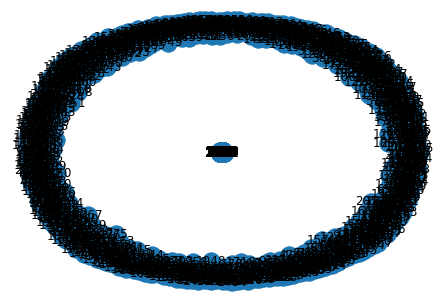

In [17]:
nx.draw(G7, with_labels = True)

---